# **Setup**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import shutil
import pickle
import pytorch_forecasting
import torch
import pytorch_lightning as pl
import torchmetrics
import tensorflow as tf

from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from joblib import Parallel, delayed
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from tf_keras.models import Sequential
from tf_keras.layers import LSTM, Dense, Dropout
from tf_keras.callbacks import EarlyStopping

from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning import Trainer
from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss, MAPE
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
from prophet import Prophet

import warnings
import logging

logging.getLogger('cmdstanpy').disabled = True
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Data Definition**

## **Global Commodity Price**

In [2]:
path = 'dataset/Global Commodity Price'
"List data pada folder Global Commodity Price:", os.listdir(path)

('List data pada folder Global Commodity Price:',
 ['Crude Oil WTI Futures Historical Data.csv',
  'Natural Gas Futures Historical Data.csv',
  'Newcastle Coal Futures Historical Data.csv',
  'Palm Oil Futures Historical Data.csv',
  'US Sugar 11 Futures Historical Data.csv',
  'US Wheat Futures Historical Data.csv'])

In [5]:
df = pd.read_csv(path + '/Palm Oil Futures Historical Data.csv')
"Untuk setiap file csv di Global Commodity Price (Crude Oil WTI Futures Historical Data.csv, dst..), Kolom-kolom nya ada:", df.columns

('Untuk setiap file csv di Global Commodity Price, Kolom-kolom nya ada:',
 Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object'))

## **Google Trend**

In [12]:
path = 'dataset/Google Trend'
"List data pada folder Google Trend:", os.listdir(path)

('List data pada folder Google Trend:',
 ['bawang',
  'bawang merah',
  'bawang putih',
  'beras',
  'cabai',
  'cabai merah',
  'cabai rawit',
  'daging',
  'daging ayam',
  'daging sapi',
  'gula',
  'minyak goreng',
  'telur ayam',
  'tepung',
  'tepung terigu'])

In [13]:
"Untuk setiap folder di Google Trend (bawang, bawang merah, dst..), List data nya adalah:", os.listdir(path + '/bawang')

('Untuk setiap folder di Google Trend (bawang, bawang merah, dst..), List data nya adalah:',
 ['Aceh.csv',
  'Bali.csv',
  'Banten.csv',
  'Bengkulu.csv',
  'DI Yogyakarta.csv',
  'DKI Jakarta.csv',
  'Gorontalo.csv',
  'Indonesia.csv',
  'Jambi.csv',
  'Jawa Barat.csv',
  'Jawa Tengah.csv',
  'Jawa Timur.csv',
  'Kalimantan Barat.csv',
  'Kalimantan Selatan.csv',
  'Kalimantan Tengah.csv',
  'Kalimantan Timur.csv',
  'Kalimantan Utara.csv',
  'Kepulauan Bangka Belitung.csv',
  'Kepulauan Riau.csv',
  'Lampung.csv',
  'Maluku Utara.csv',
  'Maluku.csv',
  'Nusa Tenggara Barat.csv',
  'Nusa Tenggara Timur.csv',
  'Papua Barat.csv',
  'Papua.csv',
  'Riau.csv',
  'Sulawesi Barat.csv',
  'Sulawesi Selatan.csv',
  'Sulawesi Tengah.csv',
  'Sulawesi Tenggara.csv',
  'Sulawesi Utara.csv',
  'Sumatera Barat.csv',
  'Sumatera Selatan.csv',
  'Sumatera Utara.csv'])

In [19]:
df1 = pd.read_csv(path + '/bawang/Aceh.csv')
df2 = pd.read_csv(path + '/bawang merah/Aceh.csv')
"Untuk setiap file csv di Google Trend (bawang/Aceh.csv, bawang/Bali.csv, ..., bawang merah/Aceh, bawang merah/Bali.csv), Kolom-kolom nya ada:", df1.columns, df2.columns, "..."

('Untuk setiap file csv di Google Trend (bawang/Aceh.csv, bawang/Bali.csv, ..., bawang merah/Aceh, bawang merah/Bali.csv), Kolom-kolom nya ada:',
 Index(['Date', 'bawang'], dtype='object'),
 Index(['Date', 'bawang merah'], dtype='object'),
 '...')

## **Harga Bahan Pangan**

In [28]:
path = 'dataset/Harga Bahan Pangan'
"List data pada folder Harga Bahan Pangan:", os.listdir(path)

('List data pada folder Harga Bahan Pangan:',
 ['sample_submission.csv', 'test', 'train'])

In [29]:
"Untuk setiap folder di train dan test, List data nya adalah:", os.listdir(path + '/train')

('Untuk setiap folder di train dan test, List data nya adalah:',
 ['Bawang Merah.csv',
  'Bawang Putih Bonggol.csv',
  'Beras Medium.csv',
  'Beras Premium.csv',
  'Cabai Merah Keriting.csv',
  'Cabai Rawit Merah.csv',
  'Daging Ayam Ras.csv',
  'Daging Sapi Murni.csv',
  'Gula Konsumsi.csv',
  'Minyak Goreng Curah.csv',
  'Minyak Goreng Kemasan Sederhana.csv',
  'Telur Ayam Ras.csv',
  'Tepung Terigu (Curah).csv'])

In [30]:
df = pd.read_csv(path + '/train/Bawang Merah.csv')
"Kolom-kolom untuk setiap data di dalam folder train dan test adalah:", df.columns

('Kolom-kolom untuk setiap data di dalam folder train dan test adalah:',
 Index(['Date', 'Aceh', 'Bali', 'Banten', 'Bengkulu', 'DI Yogyakarta',
        'DKI Jakarta', 'Gorontalo', 'Jambi', 'Jawa Barat', 'Jawa Tengah',
        'Jawa Timur', 'Kalimantan Barat', 'Kalimantan Selatan',
        'Kalimantan Tengah', 'Kalimantan Timur', 'Kalimantan Utara',
        'Kepulauan Bangka Belitung', 'Kepulauan Riau', 'Lampung',
        'Maluku Utara', 'Maluku', 'Nusa Tenggara Barat', 'Nusa Tenggara Timur',
        'Papua Barat', 'Papua', 'Riau', 'Sulawesi Barat', 'Sulawesi Selatan',
        'Sulawesi Tengah', 'Sulawesi Tenggara', 'Sulawesi Utara',
        'Sumatera Barat', 'Sumatera Selatan', 'Sumatera Utara'],
       dtype='object'))

# **Forecasting**

## **Global Commodity Forecast**

In [9]:
os.makedirs('dataset/Global Commodity Price Forecast', exist_ok=True)

def forecast_time_series(df, date_col, value_col, future_periods):
    df = df[[date_col, value_col]].rename(columns={date_col: 'ds', value_col: 'y'})
    df['y'] = df['y'].fillna(method='ffill').fillna(0)
    
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=future_periods)
    forecast = model.predict(future)
    
    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': date_col, 'yhat': value_col})
    return forecast

def process_file(file_path, future_days):
    df = pd.read_csv(file_path)

    try:
        df['Price'] = df['Price'].str.replace(',', '').astype(float)
        df['Open'] = df['Open'].str.replace(',', '').astype(float)
        df['High'] = df['High'].str.replace(',', '').astype(float)
        df['Low'] = df['Low'].str.replace(',', '').astype(float)
    except AttributeError:
        pass
    
    df['Date'] = pd.to_datetime(df['Date'])
    df['Vol.'] = df['Vol.'].str.replace('K', '000').str.replace('M', '000000').str.replace('-', '0').astype(float)
    df['Change %'] = df['Change %'].str.replace('%', '').str.replace('-', '0').astype(float)

    forecast_price = forecast_time_series(df, 'Date', 'Price', future_days)
    forecast_open = forecast_time_series(df, 'Date', 'Open', future_days)
    forecast_high = forecast_time_series(df, 'Date', 'High', future_days)
    forecast_low = forecast_time_series(df, 'Date', 'Low', future_days)
    forecast_vol = forecast_time_series(df, 'Date', 'Vol.', future_days)
    forecast_change = forecast_time_series(df, 'Date', 'Change %', future_days)

    merged_forecast = forecast_price.merge(forecast_open, on='Date', suffixes=('_price', '_open')) \
        .merge(forecast_high, on='Date') \
        .merge(forecast_low, on='Date') \
        .merge(forecast_vol, on='Date') \
        .merge(forecast_change, on='Date')

    return merged_forecast

folder_path = 'dataset/Global Commodity Price/'
future_days = (pd.to_datetime("2024-12-31") - pd.to_datetime("2024-10-31")).days

for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        print(f'Processing: {file_name}')
        forecast_df = process_file(file_path, future_days)
        save_path = os.path.join('dataset/Global Commodity Price Forecast', file_name)
        forecast_df.to_csv(save_path, index=False)
        print(f'Saved: {save_path}')

print('Forecasting selesai untuk semua file.')

Processing: Crude Oil WTI Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\Crude Oil WTI Futures Historical Data.csv
Processing: Natural Gas Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\Natural Gas Futures Historical Data.csv
Processing: Newcastle Coal Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\Newcastle Coal Futures Historical Data.csv
Processing: Palm Oil Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\Palm Oil Futures Historical Data.csv
Processing: US Sugar 11 Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\US Sugar 11 Futures Historical Data.csv
Processing: US Wheat Futures Historical Data.csv
Saved: dataset/Global Commodity Price Forecast\US Wheat Futures Historical Data.csv
Forecasting selesai untuk semua file.


## **Google Trend Forecast**

In [10]:
os.makedirs('dataset/Google Trend Forecast', exist_ok=True)

input_path = 'dataset/Google Trend'
output_path = 'dataset/Google Trend Forecast'

for folder_name in os.listdir('dataset/Google Trend'):
    if os.path.isdir(os.path.join('dataset/Google Trend', folder_name)):
        os.makedirs(os.path.join('dataset/Google Trend Forecast', folder_name), exist_ok=True)

print('Forecasting selesai untuk semua file.')

Forecasting selesai untuk semua file.


In [11]:
def forecast_time_series(df, date_col, value_col, future_periods):
    df = df[[date_col, value_col]].rename(columns={date_col: 'ds', value_col: 'y'})
    df['y'] = df['y'].fillna(method='ffill').fillna(0)
    
    model = Prophet()
    model.fit(df)
    
    future = model.make_future_dataframe(periods=future_periods)
    forecast = model.predict(future)
    
    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': date_col, 'yhat': value_col})
    return forecast

for category in os.listdir(input_path):
    category_path = os.path.join(input_path, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_path, category)
        os.makedirs(output_category_path, exist_ok=True)
        
        for file in os.listdir(category_path):
            if file.endswith('.csv'):
                file_path = os.path.join(category_path, file)

                df = pd.read_csv(file_path)
                df['Date'] = pd.to_datetime(df['Date'])
                future_days = (pd.to_datetime("2024-12-31") - df['Date'].max()).days
                
                col_name = df.columns[1]

                try:
                    forecast_df = forecast_time_series(df, 'Date', col_name, future_days)
                except ValueError as e:
                    print(f"Error: {category}/{file} - {e}")
                
                output_file_path = os.path.join(output_category_path, file)
                forecast_df.to_csv(output_file_path, index=False)
                print(f"Saved forecast for {category}/{file}")

Saved forecast for bawang/Aceh.csv
Saved forecast for bawang/Bali.csv
Saved forecast for bawang/Banten.csv
Saved forecast for bawang/Bengkulu.csv
Saved forecast for bawang/DI Yogyakarta.csv
Saved forecast for bawang/DKI Jakarta.csv
Saved forecast for bawang/Gorontalo.csv
Saved forecast for bawang/Indonesia.csv
Saved forecast for bawang/Jambi.csv
Saved forecast for bawang/Jawa Barat.csv
Saved forecast for bawang/Jawa Tengah.csv
Saved forecast for bawang/Jawa Timur.csv
Saved forecast for bawang/Kalimantan Barat.csv
Saved forecast for bawang/Kalimantan Selatan.csv
Saved forecast for bawang/Kalimantan Tengah.csv
Saved forecast for bawang/Kalimantan Timur.csv
Saved forecast for bawang/Kalimantan Utara.csv
Saved forecast for bawang/Kepulauan Bangka Belitung.csv
Saved forecast for bawang/Kepulauan Riau.csv
Saved forecast for bawang/Lampung.csv
Saved forecast for bawang/Maluku Utara.csv
Saved forecast for bawang/Maluku.csv
Saved forecast for bawang/Nusa Tenggara Barat.csv
Saved forecast for ba

## **Mata Uang Forecast**

In [ ]:
os.makedirs('dataset/Mata Uang Forecast', exist_ok=True)

def forecast_time_series(df, date_col, value_col, future_start, future_end):
    """
    Melakukan forecasting hanya untuk rentang waktu future_start hingga future_end,
    tanpa mengubah data historis sebelumnya.
    """
    df = df[[date_col, value_col]].rename(columns={date_col: 'ds', value_col: 'y'})
    df['y'] = df['y'].fillna(method='ffill').fillna(0)

    df_train = df[df['ds'] < future_start]

    model = Prophet()
    model.fit(df_train)

    future_dates = pd.date_range(start=future_start, end=future_end, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})

    forecast = model.predict(future_df)
    forecast = forecast[['ds', 'yhat']].rename(columns={'ds': date_col, 'yhat': value_col})
    
    return forecast

def process_file(file_path, future_start, future_end):
    df = pd.read_csv(file_path)
    df['Date'] = pd.to_datetime(df['Date'])
    df.drop(columns=['Adj Close', 'Volume'], inplace=True)

    forecast_close = forecast_time_series(df, 'Date', 'Close', future_start, future_end)
    forecast_high = forecast_time_series(df, 'Date', 'High', future_start, future_end)
    forecast_low = forecast_time_series(df, 'Date', 'Low', future_start, future_end)
    forecast_open = forecast_time_series(df, 'Date', 'Open', future_start, future_end)

    merged_forecast = forecast_close.merge(forecast_open, on='Date', suffixes=('_price', '_open')) \
        .merge(forecast_high, on='Date') \
        .merge(forecast_low, on='Date') \

    df_historical = df[df['Date'] < future_start]
    final_df = pd.concat([df_historical, merged_forecast], ignore_index=True)

    return final_df

folder_path = 'dataset/Mata Uang/'
future_start = pd.to_datetime("2024-10-01")
future_end = pd.to_datetime("2024-12-31")
for file_name in os.listdir(folder_path):
    if file_name.endswith('.csv'):
        file_path = os.path.join(folder_path, file_name)
        print(f'Processing: {file_name}')
        forecast_df = process_file(file_path, future_start, future_end)
        forecast_df = forecast_df.sort_values('Date').reset_index(drop=True)
        save_path = os.path.join('dataset/Mata Uang Forecast', file_name)
        forecast_df.to_csv(save_path, index=False)
        print(f'Saved: {save_path}')

print('Forecasting selesai untuk semua file.')

# **Data Merging**

In [12]:
dataset_path = 'dataset'
global_commodity_path = os.path.join(dataset_path, 'Global Commodity Price Forecast')
google_trend_path = os.path.join(dataset_path, 'Google Trend Forecast')
mata_uang_path = os.path.join(dataset_path, 'Mata Uang Forecast')
harga_bahan_pangan_path = os.path.join(dataset_path, 'Harga Bahan Pangan')

## **Global Commodity Price Data Merging**

In [13]:
commodity_files = os.listdir(global_commodity_path)
commodity_dfs = []

for file in tqdm(commodity_files, desc='Reading Commodity Data'):
    commodity_type = file.replace('.csv', '')
    df = pd.read_csv(os.path.join(global_commodity_path, file))
    df['commodity_type'] = commodity_type
    commodity_dfs.append(df)

commodity_df = pd.concat(commodity_dfs, ignore_index=True)
commodity_df.to_csv(os.path.join(dataset_path, 'global_commodity.csv'), index=False)

Reading Commodity Data: 100%|██████████| 6/6 [00:00<00:00, 74.26it/s]


## **Google Trend Data Merging**

In [14]:
trend_files = os.listdir(google_trend_path)
google_trend_dfs = []

for trend in tqdm(trend_files):
    trend_path = os.path.join(google_trend_path, trend)
    if os.path.isdir(trend_path):
        for file in os.listdir(trend_path):
            province = file.replace('.csv', '')
            df = pd.read_csv(os.path.join(trend_path, file))
            df.rename(columns={df.columns[1]: 'trend_score'}, inplace=True)
            df['jenis_trend'] = trend
            df['provinsi'] = province
            google_trend_dfs.append(df)

google_trend_df = pd.concat(google_trend_dfs, ignore_index=True)
google_trend_df = google_trend_df.fillna(method='ffill').fillna(0)
google_trend_df.to_csv(os.path.join(dataset_path, 'google_trend.csv'), index=False)

100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


## **Mata Uang Data Merging**

In [15]:
mata_uang_files = os.listdir(mata_uang_path)
mata_uang_dfs = []

for file in tqdm(mata_uang_files, desc='Reading Mata Uang Data'):
    mata_uang_type = file.replace('.csv', '')
    df = pd.read_csv(os.path.join(mata_uang_path, file))
    df['mata_uang_type'] = mata_uang_type
    mata_uang_dfs.append(df)

mata_uang_df = pd.concat(mata_uang_dfs, ignore_index=True)
mata_uang_df.to_csv(os.path.join(dataset_path, 'mata_uang.csv'), index=False)

Reading Mata Uang Data: 100%|██████████| 4/4 [00:00<00:00, 43.28it/s]


## **Harga Bahan Pangan Data Merging**

In [ ]:
harga_train = []
harga_test = []

folder_path = os.path.join(harga_bahan_pangan_path, "train")
for file in os.listdir(folder_path):
    bahan_pangan = file.replace('.csv', '')
    df = pd.read_csv(os.path.join(folder_path, file))
    df = df.melt(id_vars=['Date'], var_name='provinsi', value_name='harga')
    df['Date'] = pd.to_datetime(df['Date'])
    df['bahan_pangan'] = bahan_pangan
    df['id'] = df['bahan_pangan'] + '/' + df['provinsi'] + '/' + df['Date'].astype(str)
    harga_train.append(df)
    
harga_df = pd.concat(harga_train, ignore_index=True)
harga_df.to_csv(os.path.join(dataset_path, f'train.csv'), index=False)

folder_path = os.path.join(harga_bahan_pangan_path, "test")
for file in os.listdir(folder_path):
    bahan_pangan = file.replace('.csv', '')
    df = pd.read_csv(os.path.join(folder_path, file))
    df = df.melt(id_vars=['Date'], var_name='provinsi', value_name='harga')
    df['Date'] = pd.to_datetime(df['Date'])
    df['bahan_pangan'] = bahan_pangan
    df['id'] = df['bahan_pangan'] + '/' + df['provinsi'] + '/' + df['Date'].astype(str)
    harga_test.append(df)

harga_df = pd.concat(harga_test, ignore_index=True)
harga_df.to_csv(os.path.join(dataset_path, f'test.csv'), index=False)

# **Data Processing**

In [ ]:
commodity = pd.read_csv('dataset/global_commodity.csv')
trend = pd.read_csv('dataset/google_trend.csv')
mata_uang = pd.read_csv('dataset/mata_uang.csv')
train = pd.read_csv('dataset/train.csv')
test = pd.read_csv('dataset/test.csv')

In [18]:
commodity['Date'] = pd.to_datetime(commodity['Date'])
trend['Date'] = pd.to_datetime(trend['Date'])
mata_uang['Date'] = pd.to_datetime(mata_uang['Date'])
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

train['harga'] = train['harga'].fillna(method='ffill').fillna(0)

In [19]:
try:
    commodity['Price'] = commodity['Price'].str.replace(',', '').astype(float)
    commodity['Open'] = commodity['Open'].str.replace(',', '').astype(float)
    commodity['High'] = commodity['High'].str.replace(',', '').astype(float)
    commodity['Low'] = commodity['Low'].str.replace(',', '').astype(float)
    commodity['Vol.'] = commodity['Vol.'].str.replace('K', '000').str.replace('M', '000000').str.replace('-', '0').astype(float)
    commodity['Change %'] = commodity['Change %'].str.replace('%', '').str.replace('-', '0').astype(float)
except AttributeError:
    pass

In [20]:
commodity.sort_values('Date').tail()

,Date,Price,Open,High,Low,Vol.,Change %,commodity_type
1572,2024-11-30,1.435962,1.397855,1.451182,1.386578,125.687842,2.487883,Natural Gas Futures Historical Data
3823,2024-11-30,18.420170,18.744748,19.210716,18.422518,51.864582,1.474907,US Sugar 11 Futures Historical Data
2342,2024-11-30,106.625818,107.162837,105.325933,109.054405,0.007976,3.377253,Newcastle Coal Futures Historical Data
3073,2024-11-30,3960.759343,4074.803665,4134.575869,4093.447292,1.411938,-0.452773,Palm Oil Futures Historical Data
4583,2024-11-30,571.663596,603.190973,601.261995,613.283717,14.535777,0.222659,US Wheat Futures Historical Data


In [21]:
trend.sort_values('Date').tail()

,Date,trend_score,jenis_trend,provinsi
193776,2024-12-31,0.000000,cabai merah,Kepulauan Riau
194506,2024-12-31,0.000000,cabai merah,Lampung
195419,2024-12-31,0.000000,cabai merah,Maluku Utara
190309,2024-12-31,0.000000,cabai merah,Kalimantan Selatan
512091,2024-12-31,5.532605,tepung terigu,Sumatera Utara


In [22]:
mata_uang.sort_values('Date').tail()

,Date,Close,High,Low,Open,mata_uang_type
806,2024-12-30,0.273738,0.273824,0.273976,0.273892,MYRUSD=X
1615,2024-12-31,0.871072,0.875932,0.870225,0.872333,SGDUSD=X
807,2024-12-31,0.273924,0.274193,0.274154,0.274089,MYRUSD=X
2423,2024-12-31,0.037031,0.037889,0.036645,0.036889,THBUSD=X
3231,2024-12-31,14500.750768,14467.329341,14924.521397,14413.964879,USDIDR=X


In [23]:
train.sort_values('Date').tail()

,Date,provinsi,harga,bahan_pangan,id
300195,2024-09-30,Sulawesi Barat,18210.0,Gula Konsumsi,Gula Konsumsi/Sulawesi Barat/2024-09-30
301199,2024-09-30,Sulawesi Selatan,17590.0,Gula Konsumsi,Gula Konsumsi/Sulawesi Selatan/2024-09-30
302203,2024-09-30,Sulawesi Tengah,18710.0,Gula Konsumsi,Gula Konsumsi/Sulawesi Tengah/2024-09-30
291159,2024-09-30,Kepulauan Riau,15980.0,Gula Konsumsi,Gula Konsumsi/Kepulauan Riau/2024-09-30
443767,2024-09-30,Sumatera Utara,10640.0,Tepung Terigu (Curah),Tepung Terigu (Curah)/Sumatera Utara/2024-09-30


In [24]:
test.sort_values('Date').tail()

,Date,provinsi,harga,bahan_pangan,id
27323,2024-12-31,Papua,0,Gula Konsumsi,Gula Konsumsi/Papua/2024-12-31
27415,2024-12-31,Riau,17063,Gula Konsumsi,Gula Konsumsi/Riau/2024-12-31
27507,2024-12-31,Sulawesi Barat,17350,Gula Konsumsi,Gula Konsumsi/Sulawesi Barat/2024-12-31
26495,2024-12-31,Kalimantan Utara,18154,Gula Konsumsi,Gula Konsumsi/Kalimantan Utara/2024-12-31
40663,2024-12-31,Sumatera Utara,10250,Tepung Terigu (Curah),Tepung Terigu (Curah)/Sumatera Utara/2024-12-31


## **Google Trend Processing**

In [25]:
def merge_with_trend(data, trend):
    data['Date'] = pd.to_datetime(data['Date'])
    trend['Date'] = pd.to_datetime(trend['Date'])

    trend_mapping = trend[['jenis_trend', 'Date', 'provinsi', 'trend_score']].copy()

    data['key'] = 1
    trend_mapping['key'] = 1

    merged = data.merge(trend_mapping, on=['Date', 'provinsi', 'key'], how='left')

    merged = merged[merged.apply(
        lambda row: row['jenis_trend'].lower() in row['bahan_pangan'].lower() 
        if pd.notna(row['jenis_trend']) else False, axis=1
    )]

    merged.drop(columns=['key'], inplace=True)
    data.drop(columns=['key'], inplace=True)

    return merged

train_merged = merge_with_trend(train, trend)
test_merged = merge_with_trend(test, trend)
train_merged.drop(columns=['jenis_trend'], inplace=True)
test_merged.drop(columns=['jenis_trend'], inplace=True)

In [26]:
train_cleaned = train_merged.copy()
train_cleaned = train_cleaned.groupby(['Date', 'provinsi', 'harga', 'bahan_pangan', 'id'], as_index=False).agg({'trend_score': 'mean'})

temp_train = train[~train['id'].isin(train_cleaned['id'])]
temp_train = temp_train.merge(train_cleaned[['id', 'trend_score']], on='id', how='left').fillna(method='ffill').fillna(0)

final_train = pd.concat([train_cleaned, temp_train], ignore_index=True)
final_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443768 entries, 0 to 443767
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          443768 non-null  datetime64[ns]
 1   provinsi      443768 non-null  object        
 2   harga         443768 non-null  float64       
 3   bahan_pangan  443768 non-null  object        
 4   id            443768 non-null  object        
 5   trend_score   443768 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 20.3+ MB


In [27]:
test_cleaned = test_merged.copy()
test_cleaned = test_cleaned.groupby(['Date', 'provinsi', 'harga', 'bahan_pangan', 'id'], as_index=False).agg({'trend_score': 'mean'})

temp_test = test[~test['id'].isin(test_cleaned['id'])]
temp_test = temp_test.merge(test_cleaned[['id', 'trend_score']], on='id', how='left').fillna(method='ffill').fillna(0)

final_test = pd.concat([test_cleaned, temp_test], ignore_index=True)
final_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          40664 non-null  datetime64[ns]
 1   provinsi      40664 non-null  object        
 2   harga         40664 non-null  int64         
 3   bahan_pangan  40664 non-null  object        
 4   id            40664 non-null  object        
 5   trend_score   40664 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.9+ MB


## **Global Commodity Price Processing**

### **Training Data**

In [28]:
commodity_mapping = {
    'Minyak Goreng Curah': ['Crude Oil WTI Futures Historical Data', 'Palm Oil Futures Historical Data'],
    'Minyak Goreng Kemasan Sederhana': ['Crude Oil WTI Futures Historical Data', 'Palm Oil Futures Historical Data'],
    'Gula Konsumsi': ['US Sugar 11 Futures Historical Data'],
    'Tepung Terigu (Curah)': ['US Wheat Futures Historical Data'],
}

for food in final_train['bahan_pangan'].unique():
    commodity_mapping.setdefault(food, []).extend([
        'Natural Gas Futures Historical Data',
        'Newcastle Coal Futures Historical Data'
    ])

train_merged_2 = final_train.merge(commodity, on='Date', how='left')
train_merged_2 = train_merged_2[
    train_merged_2.apply(lambda row: row['commodity_type'] in commodity_mapping[row['bahan_pangan']], axis=1)
]

train_merged_2.fillna(0, inplace=True)
train_merged_2.reset_index(drop=True, inplace=True)

train_merged_2.drop(columns=['commodity_type'], inplace=True)
train_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 776322 entries, 0 to 776321
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          776322 non-null  datetime64[ns]
 1   provinsi      776322 non-null  object        
 2   harga         776322 non-null  float64       
 3   bahan_pangan  776322 non-null  object        
 4   id            776322 non-null  object        
 5   trend_score   776322 non-null  float64       
 6   Price         776322 non-null  float64       
 7   Open          776322 non-null  float64       
 8   High          776322 non-null  float64       
 9   Low           776322 non-null  float64       
 10  Vol.          776322 non-null  float64       
 11  Change %      776322 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 71.1+ MB


In [29]:
train_cleaned_2 = train_merged_2.copy()
train_cleaned_2 = train_cleaned_2.groupby(['Date', 'provinsi', 'harga', 'bahan_pangan', 'id', 'trend_score'], as_index=False).agg({
    'Price': 'mean',
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Vol.': 'mean',
    'Change %': 'mean'
})

temp_train_1 = final_train[~final_train['id'].isin(train_cleaned_2['id'])]
temp_train_1 = temp_train_1.merge(train_cleaned_2[['id', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']], on='id', how='left').fillna(0)

final_train_1 = pd.concat([train_cleaned_2, temp_train_1], ignore_index=True)
final_train_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 443768 entries, 0 to 443767
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          443768 non-null  datetime64[ns]
 1   provinsi      443768 non-null  object        
 2   harga         443768 non-null  float64       
 3   bahan_pangan  443768 non-null  object        
 4   id            443768 non-null  object        
 5   trend_score   443768 non-null  float64       
 6   Price         443768 non-null  float64       
 7   Open          443768 non-null  float64       
 8   High          443768 non-null  float64       
 9   Low           443768 non-null  float64       
 10  Vol.          443768 non-null  float64       
 11  Change %      443768 non-null  float64       
dtypes: datetime64[ns](1), float64(8), object(3)
memory usage: 40.6+ MB


### **Testing Data**

In [30]:
commodity_mapping = {
    'Minyak Goreng Curah': ['Crude Oil WTI Futures Historical Data', 'Palm Oil Futures Historical Data'],
    'Minyak Goreng Kemasan Sederhana': ['Crude Oil WTI Futures Historical Data', 'Palm Oil Futures Historical Data'],
    'Gula Konsumsi': ['US Sugar 11 Futures Historical Data'],
    'Tepung Terigu (Curah)': ['US Wheat Futures Historical Data'],
}

for food in final_test['bahan_pangan'].unique():
    commodity_mapping.setdefault(food, []).extend([
        'Natural Gas Futures Historical Data',
        'Newcastle Coal Futures Historical Data'
    ])

test_merged_2 = final_test.merge(commodity, on='Date', how='left')
test_merged_2 = test_merged_2[
    test_merged_2.apply(lambda row: row['commodity_type'] in commodity_mapping[row['bahan_pangan']], axis=1)
]

test_merged_2.fillna(0, inplace=True)
test_merged_2.reset_index(drop=True, inplace=True)

test_merged_2.drop(columns=['commodity_type'], inplace=True)
test_merged_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66368 entries, 0 to 66367
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          66368 non-null  datetime64[ns]
 1   provinsi      66368 non-null  object        
 2   harga         66368 non-null  int64         
 3   bahan_pangan  66368 non-null  object        
 4   id            66368 non-null  object        
 5   trend_score   66368 non-null  float64       
 6   Price         66368 non-null  float64       
 7   Open          66368 non-null  float64       
 8   High          66368 non-null  float64       
 9   Low           66368 non-null  float64       
 10  Vol.          66368 non-null  float64       
 11  Change %      66368 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 6.1+ MB


In [31]:
test_cleaned_2 = test_merged_2.copy()
test_cleaned_2 = test_cleaned_2.groupby(['Date', 'provinsi', 'harga', 'bahan_pangan', 'id', 'trend_score'], as_index=False).agg({
    'Price': 'mean',
    'Open': 'mean',
    'High': 'mean',
    'Low': 'mean',
    'Vol.': 'mean',
    'Change %': 'mean'
})

temp_test_1 = final_test[~final_test['id'].isin(test_cleaned_2['id'])]
temp_test_1 = temp_test_1.merge(test_cleaned_2[['id', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %']], on='id', how='left').fillna(0)

final_test_1 = pd.concat([test_cleaned_2, temp_test_1], ignore_index=True)
final_test_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40664 entries, 0 to 40663
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          40664 non-null  datetime64[ns]
 1   provinsi      40664 non-null  object        
 2   harga         40664 non-null  int64         
 3   bahan_pangan  40664 non-null  object        
 4   id            40664 non-null  object        
 5   trend_score   40664 non-null  float64       
 6   Price         40664 non-null  float64       
 7   Open          40664 non-null  float64       
 8   High          40664 non-null  float64       
 9   Low           40664 non-null  float64       
 10  Vol.          40664 non-null  float64       
 11  Change %      40664 non-null  float64       
dtypes: datetime64[ns](1), float64(7), int64(1), object(3)
memory usage: 3.7+ MB


## **Mata Uang Processing**

In [ ]:
final_train_2 = final_train_1.merge(mata_uang, on='Date', how='left').fillna(method='ffill').fillna(0)
final_test_2 = final_test_1.merge(mata_uang, on='Date', how='left').fillna(method='ffill').fillna(0)

# **EDA**

## **Global Commodity Price**

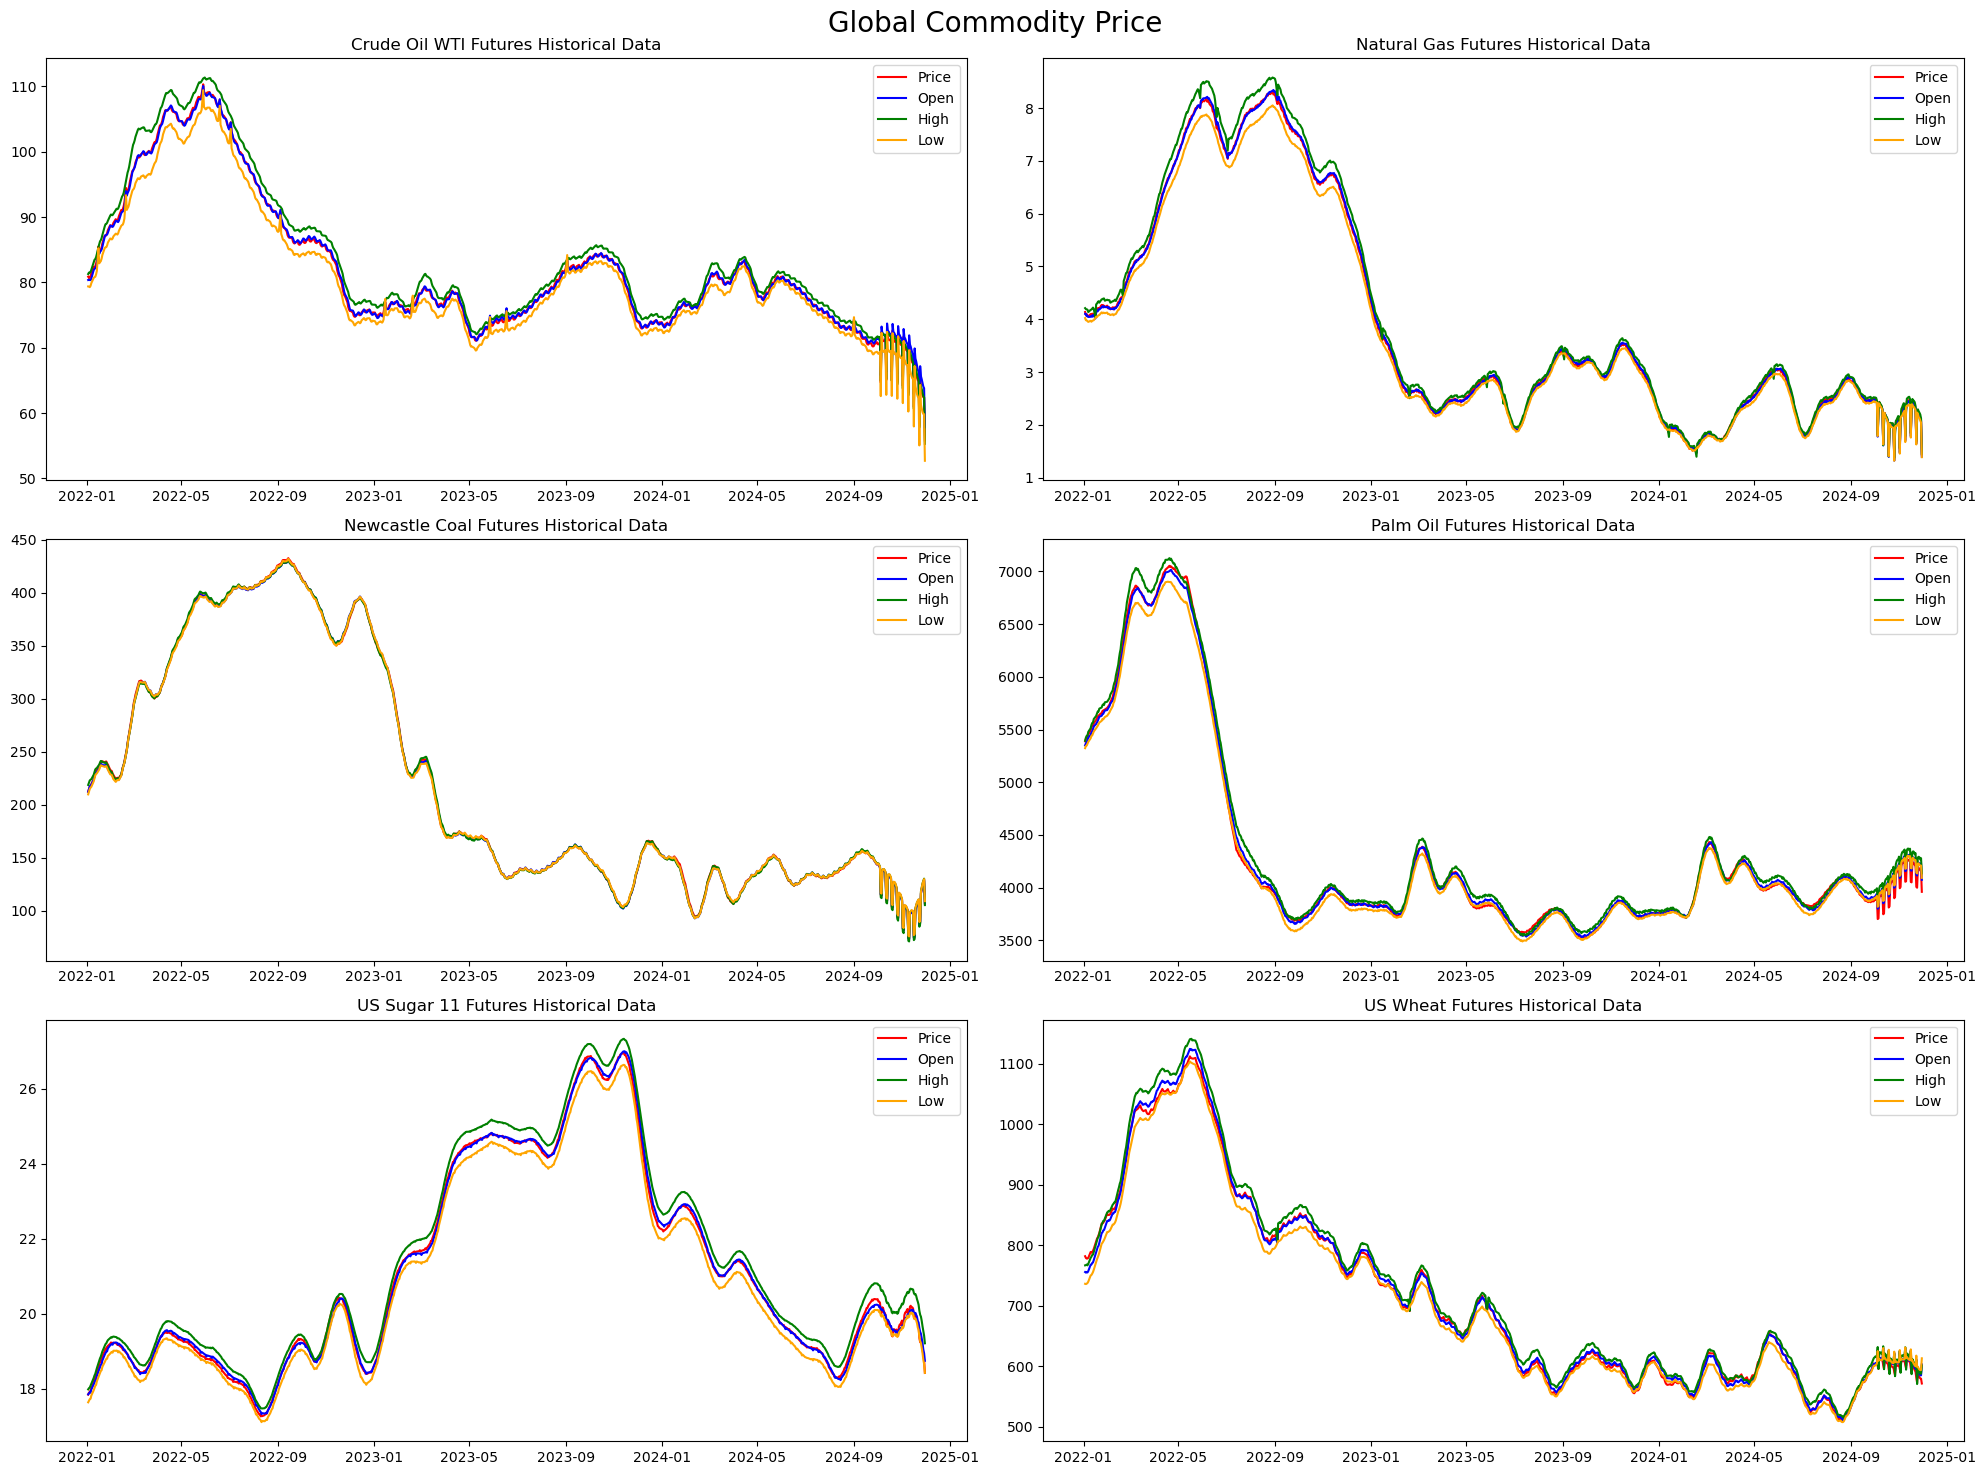

In [34]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Global Commodity Price', fontsize=20)

commodity_types = commodity['commodity_type'].unique()

for i, commodity_type in enumerate(commodity_types):
    data = commodity[(commodity['commodity_type'] == commodity_type)]
    ax[i//2, i%2].plot(data['Date'], data['Price'], label='Price', color='red')
    ax[i//2, i%2].plot(data['Date'], data['Open'], label='Open', color='blue')
    ax[i//2, i%2].plot(data['Date'], data['High'], label='High', color='green')
    ax[i//2, i%2].plot(data['Date'], data['Low'], label='Low', color='orange')
    ax[i//2, i%2].set_title(commodity_type)
    ax[i//2, i%2].legend()

plt.tight_layout()
plt.show()

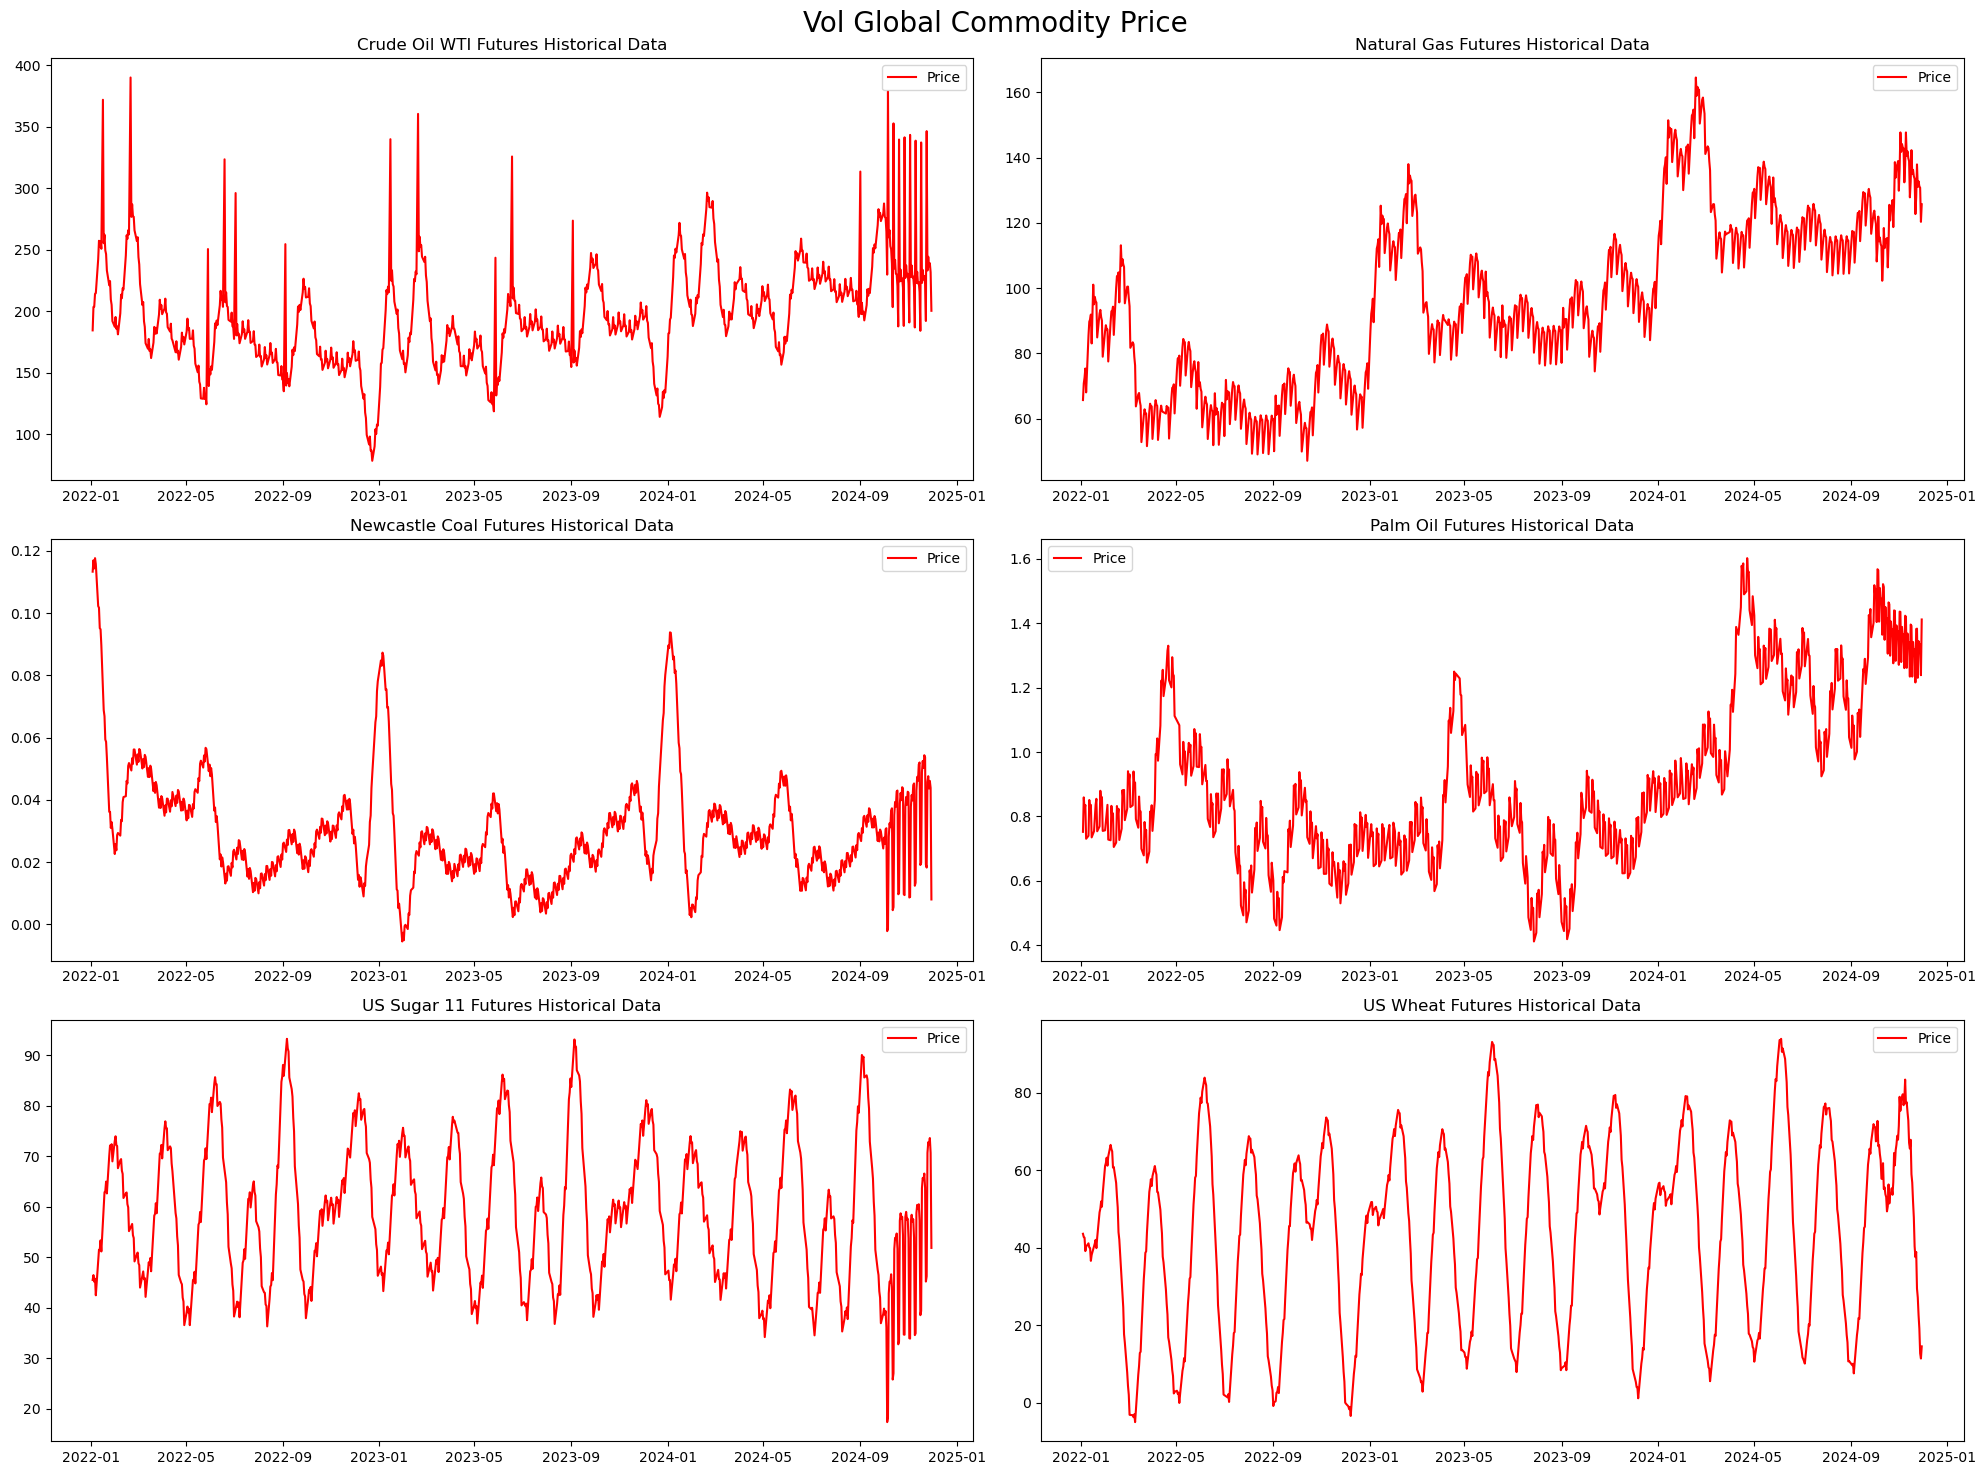

In [35]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Vol Global Commodity Price', fontsize=20)

commodity_types = commodity['commodity_type'].unique()

for i, commodity_type in enumerate(commodity_types):
    data = commodity[commodity['commodity_type'] == commodity_type]
    ax[i//2, i%2].plot(data['Date'], data['Vol.'], label='Price', color='red')
    ax[i//2, i%2].set_title(commodity_type)
    ax[i//2, i%2].legend()

plt.tight_layout()
plt.show()

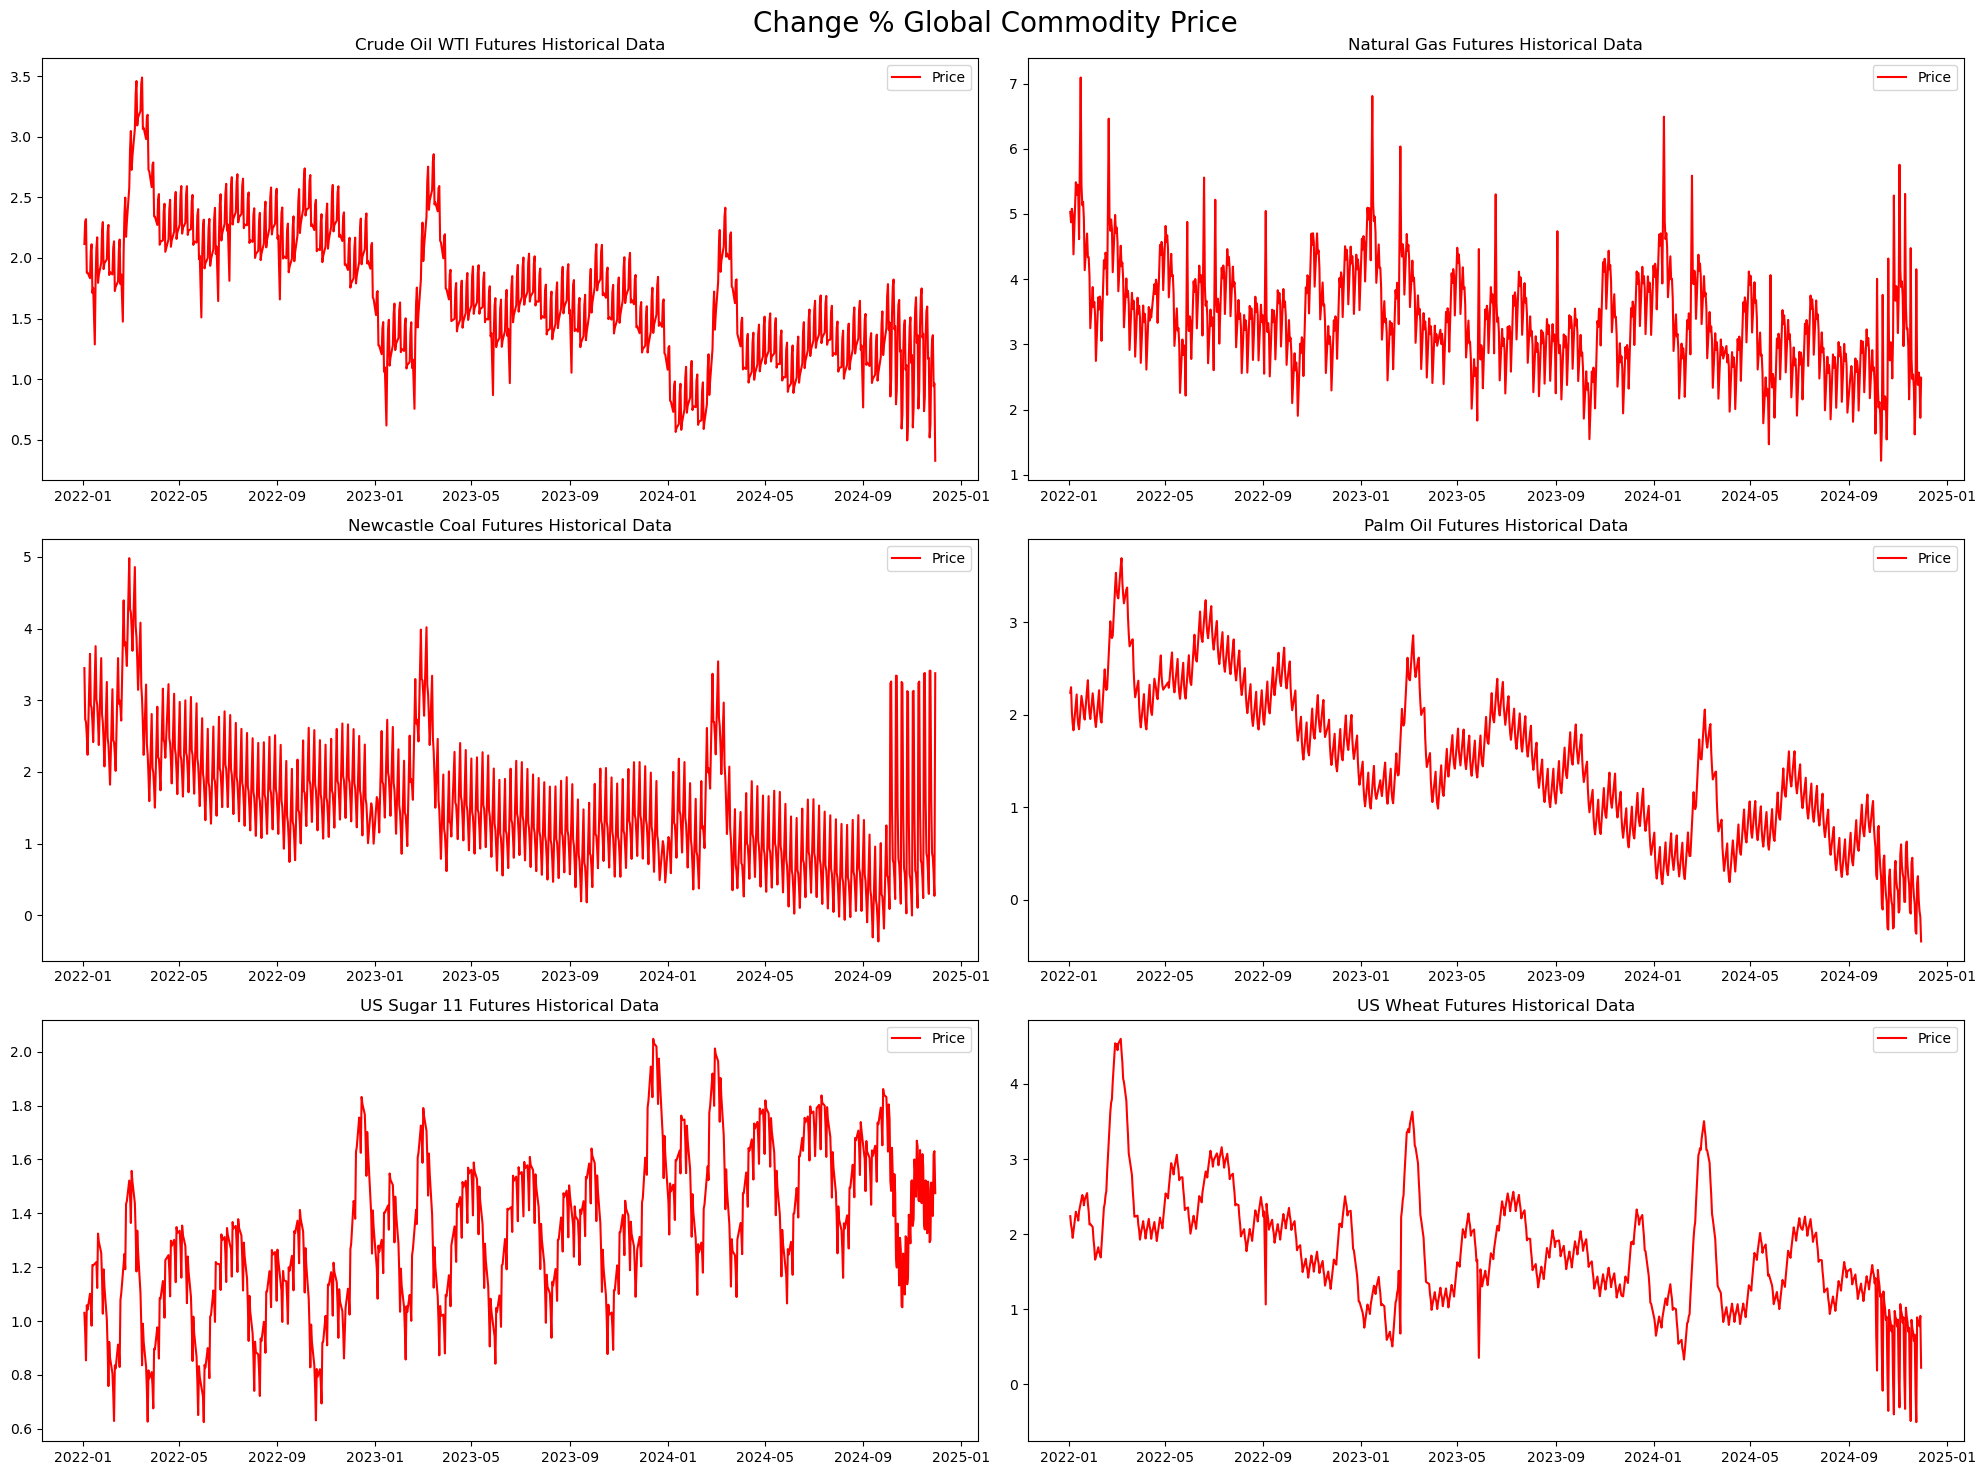

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Change % Global Commodity Price', fontsize=20)

commodity_types = commodity['commodity_type'].unique()

for i, commodity_type in enumerate(commodity_types):
    data = commodity[commodity['commodity_type'] == commodity_type]
    ax[i//2, i%2].plot(data['Date'], data['Change %'], label='Price', color='red')
    ax[i//2, i%2].set_title(commodity_type)
    ax[i//2, i%2].legend()

plt.tight_layout()
plt.show()

## **Google Trend**

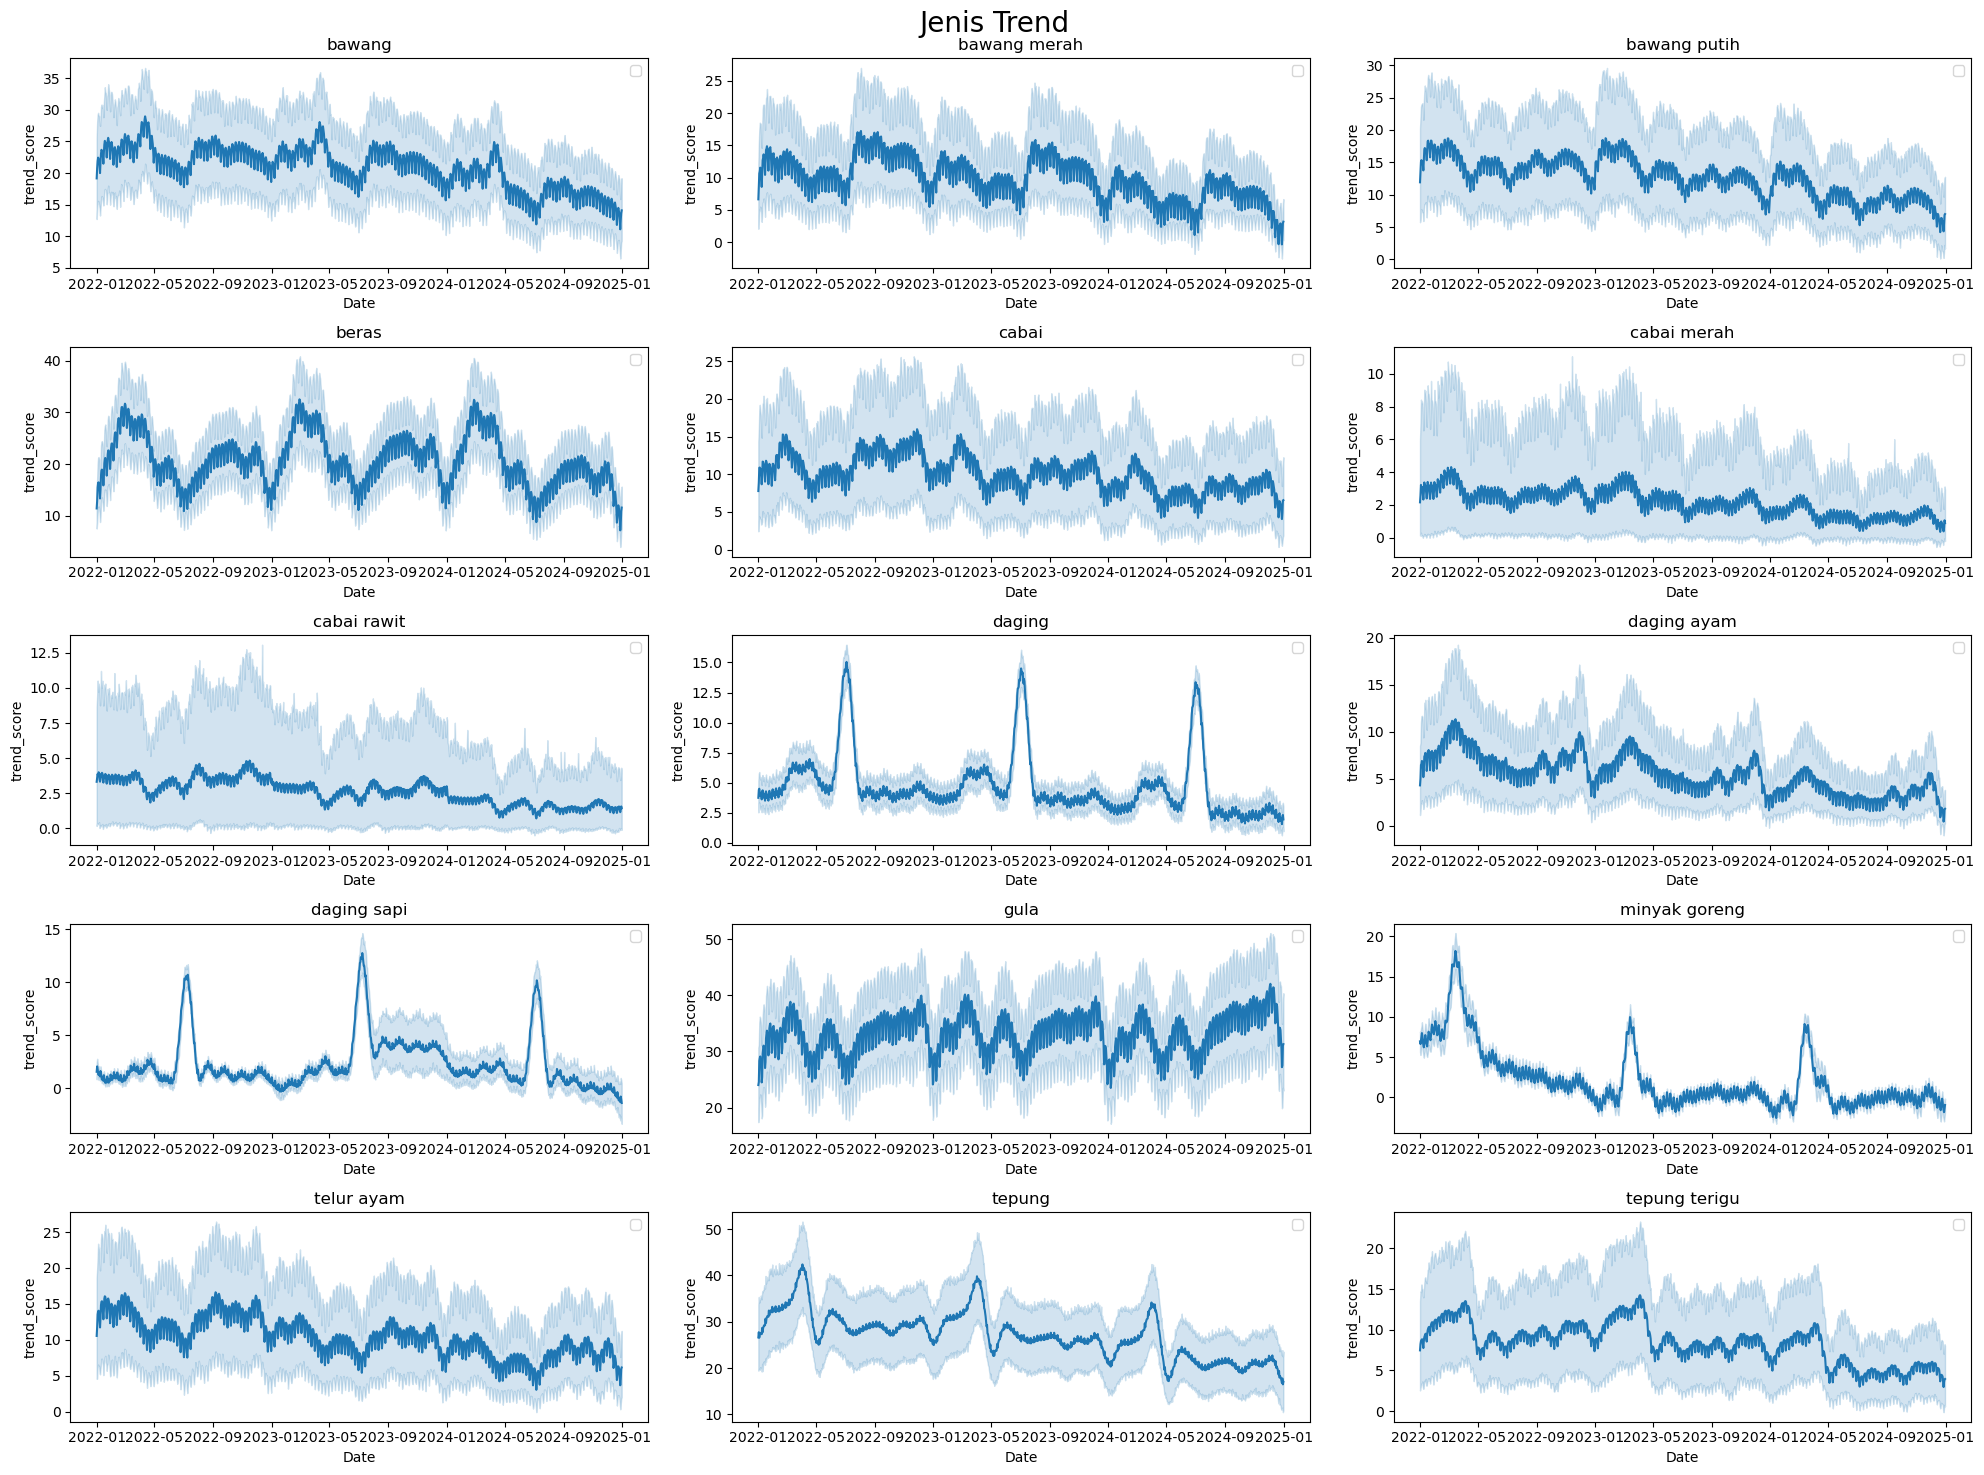

In [37]:
fig, ax = plt.subplots(5, 3, figsize=(20, 15))
fig.suptitle('Jenis Trend', fontsize=20)

trend_types = trend['jenis_trend'].unique()

for i, trend_type in enumerate(trend_types):
    data = trend[trend['jenis_trend'] == trend_type]
    sns.lineplot(data=data, x='Date', y='trend_score', ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(trend_type)
    ax[i//3, i%3].legend()

plt.tight_layout()
plt.show()

## **Mata Uang**

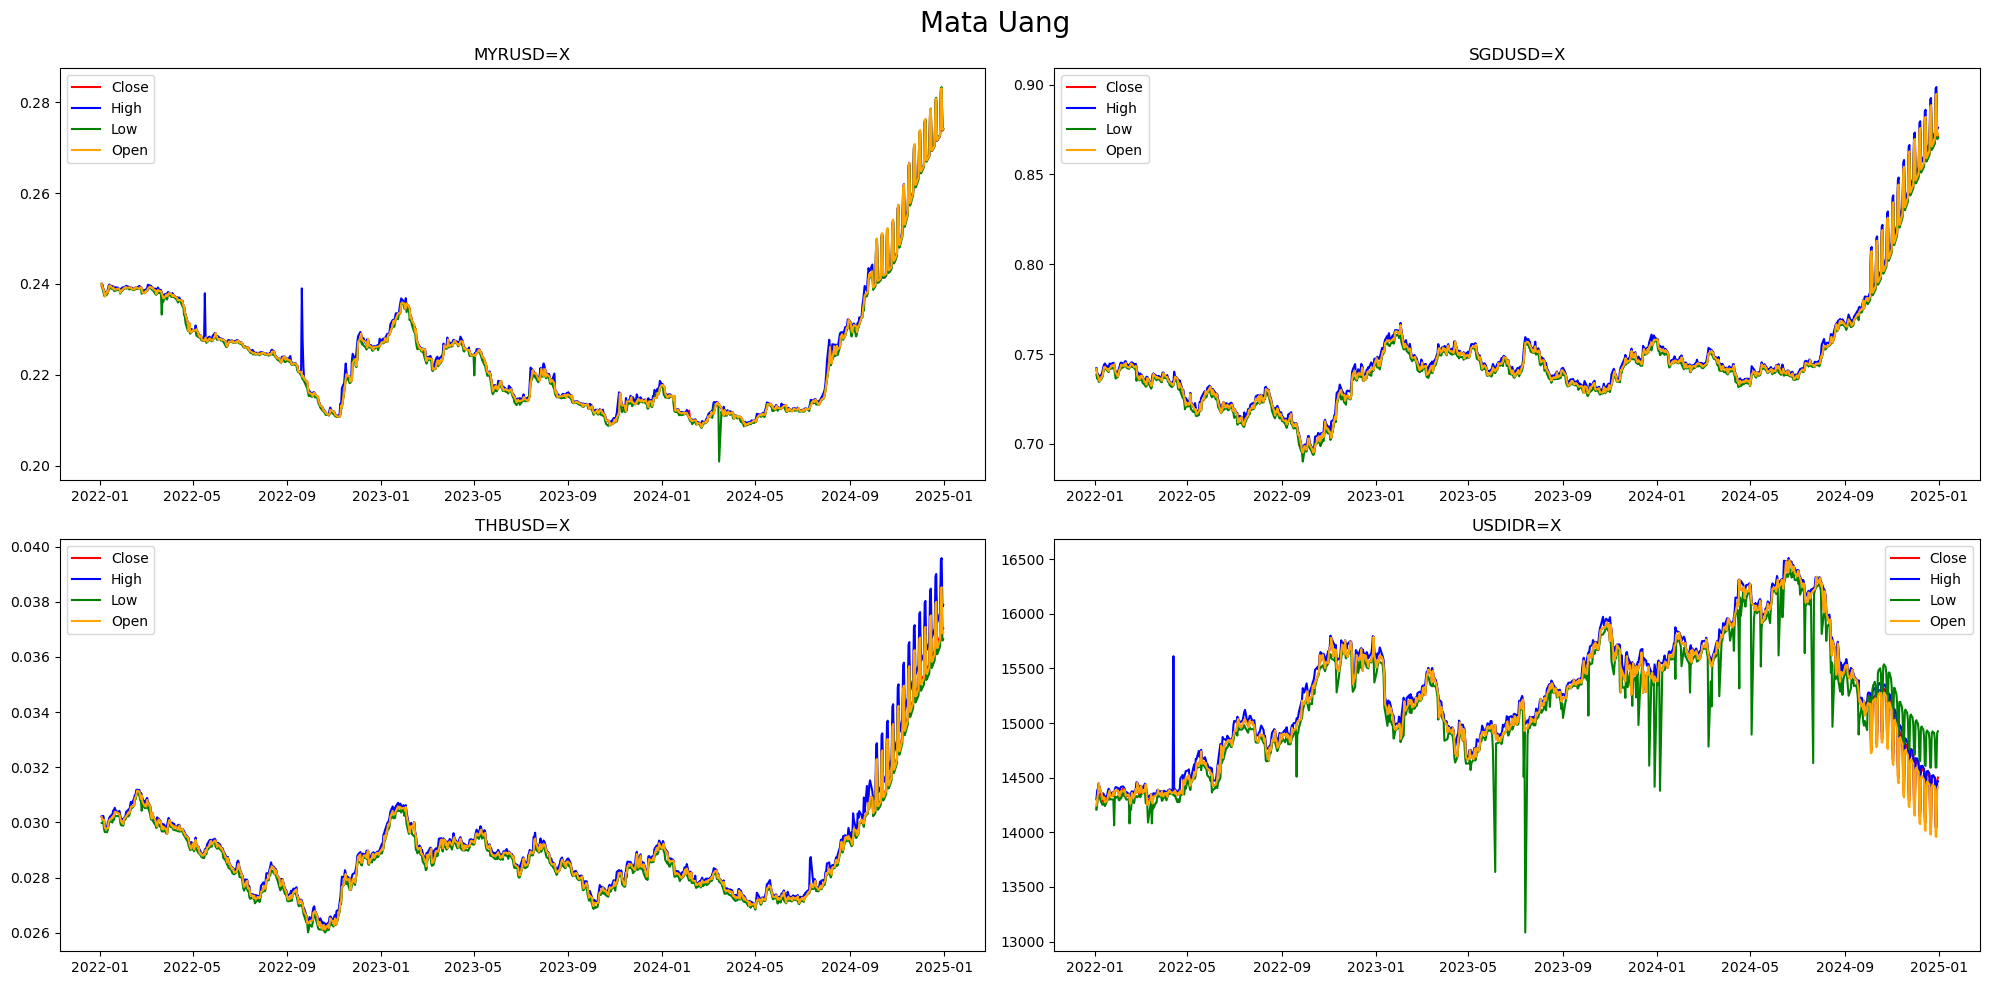

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Mata Uang', fontsize=20)

mata_uang_types = mata_uang['mata_uang_type'].unique()

for i, mata_uang_type in enumerate(mata_uang_types):
    data = mata_uang[mata_uang['mata_uang_type'] == mata_uang_type]
    ax[i//2, i%2].plot(data['Date'], data['Close'], label='Close', color='red')
    ax[i//2, i%2].plot(data['Date'], data['High'], label='High', color='blue')
    ax[i//2, i%2].plot(data['Date'], data['Low'], label='Low', color='green')
    ax[i//2, i%2].plot(data['Date'], data['Open'], label='Open', color='orange')
    ax[i//2, i%2].set_title(mata_uang_type)
    ax[i//2, i%2].legend()

plt.tight_layout()
plt.show()

# **Modeling**

## **Expand Data**

In [41]:
shutil.rmtree('dataset/Processed')

In [42]:
os.makedirs('dataset/Processed', exist_ok=True)
os.makedirs('dataset/Processed/train', exist_ok=True)
os.makedirs('dataset/Processed/test', exist_ok=True)
os.makedirs('dataset/Processed/models', exist_ok=True)
os.makedirs('dataset/Processed/predictions', exist_ok=True)

In [43]:
def data_separation(dataset, data_saved):
    for provinsi in dataset['provinsi'].unique():
        data = dataset[dataset['provinsi'] == provinsi]
        
        for bahan_pangan in data['bahan_pangan'].unique():
            data_bahan_pangan = data[data['bahan_pangan'] == bahan_pangan]

            # Pemrosesan Data Lag Features
            for i in range(1, 8):
                data_bahan_pangan[f'trend_score_{i}'] = data_bahan_pangan['trend_score'].shift(i)
                data_bahan_pangan[f'Price_{i}'] = data_bahan_pangan['Price'].shift(i)
                data_bahan_pangan[f'Open_{i}'] = data_bahan_pangan['Open'].shift(i)
                data_bahan_pangan[f'High_{i}'] = data_bahan_pangan['High'].shift(i)
                data_bahan_pangan[f'Low_{i}'] = data_bahan_pangan['Low'].shift(i)
                data_bahan_pangan[f'Vol_{i}'] = data_bahan_pangan['Vol.'].shift(i)
                data_bahan_pangan[f'Change_{i}'] = data_bahan_pangan['Change %'].shift(i)
            
            # Pemrosesan Data Time Feature
            data_bahan_pangan['year'] = data_bahan_pangan['Date'].dt.year
            data_bahan_pangan['month'] = data_bahan_pangan['Date'].dt.month
            data_bahan_pangan['day'] = data_bahan_pangan['Date'].dt.day
            data_bahan_pangan['dayofweek'] = data_bahan_pangan['Date'].dt.dayofweek
            data_bahan_pangan['dayofyear'] = data_bahan_pangan['Date'].dt.dayofyear

            data_bahan_pangan = data_bahan_pangan.fillna(method='ffill').fillna(0)
            data_bahan_pangan.drop(columns=['bahan_pangan', 'provinsi', 'Date'], inplace=True)

            data_bahan_pangan.to_csv(f'dataset/Processed/{data_saved}/{bahan_pangan}-{provinsi}.csv', index=False)

data_separation(final_train_1, 'train')
data_separation(final_test_1, 'test')

## **Selecting Data**

### **LGBM**

In [ ]:
def train_model(file_path, save_path):
    data = pd.read_csv(file_path)
    
    split_idx = int(len(data) * 0.8)
    train_data, test_data = data.iloc[:split_idx], data.iloc[split_idx:]

    features0 = ['year', 'month', 'day', 'dayofweek', 'dayofyear']
    features1 = [col for col in test_data.columns if "trend_score" in col]
    features2 = [col for col in test_data.columns if "Price" in col]
    features3 = [col for col in test_data.columns if "Open" in col]
    features4 = [col for col in test_data.columns if "High" in col]
    features5 = [col for col in test_data.columns if "Low" in col]
    features6 = [col for col in test_data.columns if "Vol" in col]
    features7 = [col for col in test_data.columns if "Change" in col]
    features8 = [col for col in test_data.columns if "_" in col]
    features = list(set(features0 + features1 + features2 + features3 + features4 + features5 + features6 + features7 + features8))

    target = "harga"

    params = {
        'random_state': 42,
        'verbosity': -1
    }

    model = LGBMRegressor(**params)

    model.fit(
        train_data[features], train_data[target], 
        eval_set=[(test_data[features], test_data[target])]
    )

    with open(save_path, "wb") as f:
        pickle.dump(model, f)

    preds = model.predict(test_data[features])
    
    mape = mean_absolute_percentage_error(test_data[target], preds)
    rmse = np.sqrt(mean_squared_error(test_data[target], preds))
    
    return file_path, mape, rmse

train_files = [os.path.join("dataset/Processed/train", f) for f in os.listdir("dataset/Processed/train")]
model_save_paths = [os.path.join("dataset/Processed/models", f.replace(".csv", ".pkl")) for f in os.listdir("dataset/Processed/train")]

results = Parallel(n_jobs=-1)(delayed(train_model)(file, save) for file, save in zip(train_files, model_save_paths))

evaluation_df = pd.DataFrame(results, columns=["dataset", "MAPE", "RMSE"])
evaluation_df.to_csv("dataset/Processed/models/evaluation_metrics.csv", index=False)

print("Training selesai. Model tersimpan di dataset/Processed/models/")
print("Mape: ", evaluation_df['MAPE'].mean())
print("RMSE: ", evaluation_df['RMSE'].mean())

Training selesai. Model tersimpan di dataset/Processed/models/
Mape:  0.06513777324364174
RMSE:  2197.807611204322


### **ARIMA**

In [ ]:
def train_arima(file_path, save_path):
    try:
        data = pd.read_csv(file_path)

        if not all(col in data.columns for col in ["year", "month", "day", "harga"]):
            print(f"Skipping {file_path}: Missing necessary columns.")
            return file_path, np.nan, np.nan

        data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
        data = data.sort_values(by='date')

        target = "harga"
    
        if len(data) < 10:
            print(f"Skipping {file_path}: Not enough data points.")
            return file_path, np.nan, np.nan

        split_idx = int(len(data) * 0.8)
        train_data, test_data = data.iloc[:split_idx], data.iloc[split_idx:]

        if len(test_data) == 0:
            print(f"Skipping {file_path}: Test set is empty.")
            return file_path, np.nan, np.nan
    
        model = ARIMA(train_data[target]) 
        model_fit = model.fit()

        with open(save_path, "wb") as f:
            pickle.dump(model_fit, f)

        preds = model_fit.forecast(steps=len(test_data))
            
        mape = mean_absolute_percentage_error(test_data[target], preds)
        rmse = np.sqrt(mean_squared_error(test_data[target], preds))

        return file_path, mape, rmse

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return file_path, np.nan, np.nan

train_files = [os.path.join("dataset/Processed/train", f) for f in os.listdir("dataset/Processed/train")]
model_save_paths = [os.path.join("dataset/Processed/models", f.replace(".csv", ".pkl")) for f in os.listdir("dataset/Processed/train")]

results = Parallel(n_jobs=-1)(delayed(train_arima)(file, save) for file, save in zip(train_files, model_save_paths))

evaluation_df = pd.DataFrame(results, columns=["dataset", "MAPE", "RMSE"])
evaluation_df.to_csv("dataset/Processed/models/evaluation_metrics_arima.csv", index=False)

print("Training selesai. Model tersimpan di dataset/Processed/models/")
print("MAPE rata-rata: ", evaluation_df['MAPE'].mean())
print("RMSE rata-rata: ", evaluation_df['RMSE'].mean())

Training selesai. Model tersimpan di dataset/Processed/models/
MAPE rata-rata:  0.08926920543802391
RMSE rata-rata:  2506.2860008304688


### **LSTM**

In [ ]:
def train_lstm(file_path, save_path):
    try:
        data = pd.read_csv(file_path)

        split_idx = int(len(data) * 0.8)
        train_data, test_data = data.iloc[:split_idx], data.iloc[split_idx:]
    
        features0 = ['year', 'month', 'day', 'dayofweek', 'dayofyear']
        features1 = [col for col in test_data.columns if "trend_score" in col]
        features2 = [col for col in test_data.columns if "Price" in col]
        features3 = [col for col in test_data.columns if "Open" in col]
        features4 = [col for col in test_data.columns if "High" in col]
        features5 = [col for col in test_data.columns if "Low" in col]
        features6 = [col for col in test_data.columns if "Vol" in col]
        features7 = [col for col in test_data.columns if "Change" in col]
        features8 = [col for col in test_data.columns if "_" in col]
        features = list(set(features0 + features1 + features2 + features3 + features4 + features5 + features6 + features7 + features8))

        target = "harga"
    
        if len(train_data) == 0 or len(test_data) == 0:
            print(f"Skipping {file_path}: Train/test set is empty.")
            return file_path, np.nan, np.nan

        scaler = MinMaxScaler()

        train_scaled = scaler.fit_transform(train_data[features])
        test_scaled = scaler.transform(test_data[features])

        X_train = np.reshape(train_scaled, (train_scaled.shape[0], 1, train_scaled.shape[1]))
        X_test = np.reshape(test_scaled, (test_scaled.shape[0], 1, test_scaled.shape[1]))
        y_train = train_data[target].values
        y_test = test_data[target].values

        model = Sequential([
            LSTM(50, activation='relu', return_sequences=True, input_shape=(1, len(features))),
            Dropout(0.2),
            LSTM(50, activation='relu'),
            Dropout(0.2),
            Dense(1)
        ])

        model.compile(optimizer='adam', loss='mse')
    
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

        model.fit(
            X_train, y_train,
            epochs=25,
            batch_size=32,
            validation_data=(X_test, y_test),
            callbacks=[early_stopping],
            verbose=1
        )
    
        model.save(save_path)

        preds = model.predict(X_test).flatten()
    
        mape = mean_absolute_percentage_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))

        return file_path, mape, rmse

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return file_path, np.nan, np.nan

train_files = [os.path.join("dataset/Processed/train", f) for f in os.listdir("dataset/Processed/train")]
model_save_paths = [os.path.join("dataset/Processed/models", f.replace(".csv", ".h5")) for f in os.listdir("dataset/Processed/train")]

results = Parallel(n_jobs=-1)(delayed(train_lstm)(file, save) for file, save in zip(train_files, model_save_paths))

evaluation_df = pd.DataFrame(results, columns=["dataset", "MAPE", "RMSE"])
evaluation_df.to_csv("dataset/Processed/models/evaluation_metrics_lstm.csv", index=False)

print("Training selesai. Model LSTM tersimpan di dataset/Processed/models/")
print("MAPE rata-rata: ", evaluation_df['MAPE'].mean())
print("RMSE rata-rata: ", evaluation_df['RMSE'].mean())

Training selesai. Model LSTM tersimpan di dataset/Processed/models/
MAPE rata-rata:  0.05565325328328449
RMSE rata-rata:  2007.1838692759302


### **TFT**

In [ ]:
def train_tft(file_path, save_path):
    try:
        data = pd.read_csv(file_path)

        data['date']      = pd.to_datetime(data[['year', 'month', 'day']])
        data["id"]        = data["id"].apply(lambda x: "/".join(x.split("/")[:2]))  
        data["time_diff"] = data.groupby("id")["dayofyear"].diff()
        data["valid"]     = data.groupby("id")["dayofyear"].transform(
            lambda x: (x.max() - x.min()) >= (max_encoder_length + max_prediction_length)
        )
        data["time_idx"]  = data.groupby("id").cumcount()

        data = data.sort_values(["id", "dayofyear"])
        data = data.rename(columns={"Vol.": "Vol", "Change %": "ChangePct"})
        data = data.sort_values(by=['date'])

        split_idx = int(len(data) * 0.8)
        train_data, test_data = data.iloc[:split_idx], data.iloc[split_idx:]
        
        target = "harga"
        
        features0 = ['year', 'month', 'day', 'dayofweek', 'dayofyear']
        features1 = [col for col in test_data.columns if "trend_score" in col]
        features2 = [col for col in test_data.columns if "Price" in col]
        features3 = [col for col in test_data.columns if "Open" in col]
        features4 = [col for col in test_data.columns if "High" in col]
        features5 = [col for col in test_data.columns if "Low" in col]
        features6 = [col for col in test_data.columns if "Vol" in col]
        features7 = [col for col in test_data.columns if "Change" in col]
        features8 = [col for col in test_data.columns if "_" in col]
        features = list(set(features0 + features1 + features2 + features3 + features4 + features5 + features6 + features7 + features8))
        
        scaler = MinMaxScaler()
        data[features] = scaler.fit_transform(data[features])
        
        max_encoder_length = 30  
        max_prediction_length = 7  

        dataset = TimeSeriesDataSet(
            data,
            time_idx="time_idx",  
            target="harga",
            group_ids=["id"],
            min_encoder_length=max_encoder_length // 2,
            max_encoder_length=max_encoder_length,
            min_prediction_length=1,
            categorical_encoders={"id": NaNLabelEncoder()},
            max_prediction_length=max_prediction_length,
            static_categoricals=[],
            time_varying_known_reals=features,
            time_varying_unknown_reals=[target],
        )
        
        train_dataloader = dataset.to_dataloader(train=True, batch_size=64, num_workers=0)
        test_dataloader = dataset.to_dataloader(train=False, batch_size=64, num_workers=0)
        
        model = TemporalFusionTransformer.from_dataset(
            dataset,
            learning_rate=0.03,
            hidden_size=16,
            attention_head_size=4,
            dropout=0.1,
            loss=QuantileLoss(),
            output_size=7,  
            log_interval=10,
            reduce_on_plateau_patience=4,
        )
        
        trainer = pl.Trainer(
            max_epochs=25,
            gradient_clip_val=0.1,
            accelerator="auto",
        )
        
        trainer.fit(model, train_dataloader)
        torch.save(model.state_dict(), save_path)
        
        predictions = model.predict(test_dataloader).detach().numpy().flatten()
        y_test = test_data[target].values[:len(predictions)]
        
        mape = mean_absolute_percentage_error(y_test, predictions)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        
        return file_path, mape, rmse
    
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return file_path, np.nan, np.nan

train_files = [os.path.join("dataset/Processed/train", f) for f in os.listdir("dataset/Processed/train")]
model_save_paths = [os.path.join("dataset/Processed/models", f.replace(".csv", ".pt")) for f in os.listdir("dataset/Processed/train")]

results = Parallel(n_jobs=-1)(delayed(train_tft)(file, save) for file, save in zip(train_files, model_save_paths))

evaluation_df = pd.DataFrame(results, columns=["dataset", "MAPE", "RMSE"])
evaluation_df.to_csv("dataset/Processed/models/evaluation_metrics_tft.csv", index=False)

print("Training selesai. Model TFT tersimpan di dataset/Processed/models/")
print("MAPE rata-rata: ", evaluation_df['MAPE'].mean())
print("RMSE rata-rata: ", evaluation_df['RMSE'].mean())

Training selesai. Model TFT tersimpan di dataset/Processed/models/
MAPE rata-rata:  0.049531492481221
RMSE rata-rata:  1771.1298412484834


## **Training Data**

### **Hyperparameter**

In [ ]:
def prepare_data(file_path, max_encoder_length=30, max_prediction_length=7):
    data = pd.read_csv(file_path)
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    data['id'] = data['id'].apply(lambda x: "/".join(x.split("/")[:2]))
    data['time_idx'] = data.groupby("id").cumcount()
    data = data.sort_values(by=['id', 'date'])
    
    features = [col for col in data.columns if col not in ['id', 'date', 'harga']]
    scaler = MinMaxScaler()
    data[features] = scaler.fit_transform(data[features])
    
    dataset = TimeSeriesDataSet(
        data,
        time_idx="time_idx",
        target="harga",
        group_ids=["id"],
        min_encoder_length=max_encoder_length // 2,
        max_encoder_length=max_encoder_length,
        min_prediction_length=1,
        max_prediction_length=max_prediction_length,
        time_varying_known_reals=features,
        time_varying_unknown_reals=["harga"],
        categorical_encoders={"id": NaNLabelEncoder()},
    )
    
    train_size = int(len(data) * 0.8)
    train_dataloader = dataset.to_dataloader(train=True, batch_size=64, num_workers=0)
    val_dataloader = dataset.to_dataloader(train=False, batch_size=64, num_workers=0)
    
    return dataset, train_dataloader, val_dataloader

def hyperparameter_tuning(train_dataloader, val_dataloader):
    study = optimize_hyperparameters(
        train_dataloader,
        val_dataloader,
        model_path="optuna_test",
        n_trials=50,
        max_epochs=20,
        gradient_clip_val_range=(0.01, 1.0),
        hidden_size_range=(8, 64),
        hidden_continuous_size_range=(8, 64),
        attention_head_size_range=(1, 4),
        learning_rate_range=(0.001, 0.1),
        dropout_range=(0.1, 0.3),
        trainer_kwargs=dict(limit_train_batches=100, limit_val_batches=100, log_every_n_steps=15, accelerator="auto"),
        reduce_on_plateau_patience=4,
        use_learning_rate_finder=False,
        timeout=7200,
    )
    return study.best_trial.params

def train_tft(file_path, save_path, best_params):
    dataset, train_dataloader, val_dataloader = prepare_data(file_path)
    
    model = TemporalFusionTransformer.from_dataset(
        dataset=dataset,
        learning_rate=best_params['learning_rate'],
        hidden_size=best_params['hidden_size'],
        attention_head_size=best_params['attention_head_size'],
        dropout=best_params['dropout'],
        loss=QuantileLoss(),
        log_interval=10,
        reduce_on_plateau_patience=4,
    )
    
    trainer = pl.Trainer(
        max_epochs=25,
        gradient_clip_val=best_params['gradient_clip_val'],
        accelerator="auto",
    )
    trainer.fit(model, train_dataloader)
    torch.save(model.state_dict(), save_path)
    
    predictions = model.predict(val_dataloader).detach().numpy().flatten()
    y_test = dataset.data["harga"].values[:len(predictions)]
    
    mape = mean_absolute_percentage_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    
    return file_path, mape, rmse

if __name__ == "__main__":
    train_files = [os.path.join("dataset/Processed/train", f) for f in os.listdir("dataset/Processed/train")]
    model_save_paths = [os.path.join("dataset/Processed/models", f.replace(".csv", ".pt")) for f in os.listdir("dataset/Processed/train")]
    
    dataset, train_dataloader, val_dataloader = prepare_data(train_files[0])
    best_params = hyperparameter_tuning(train_dataloader, val_dataloader)
    
    results = [train_tft(file, save, best_params) for file, save in zip(train_files, model_save_paths)]
    evaluation_df = pd.DataFrame(results, columns=["dataset", "MAPE", "RMSE"])
    evaluation_df.to_csv("dataset/Processed/models/evaluation_metrics_tft.csv", index=False)

In [ ]:
print("Training selesai. Model TFT tersimpan di dataset/Processed/models/")
print("MAPE rata-rata: ", evaluation_df['MAPE'].mean())
print("RMSE rata-rata: ", evaluation_df['RMSE'].mean())

Training selesai. Model TFT tersimpan di dataset/Processed/models/
MAPE rata-rata:  0.004012612938127
RMSE rata-rata:  1471.1298412484834
